In [1]:
import umap
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.neighbors import kneighbors_graph
import networkx as nx


In [8]:
def getData(tr_file, te_file, expt=None):
    """
    tr_file: training data file
    te_file: testing data file
    expt: overexpress or delete (of course, can be obtained from the filename!)
    """
    df_tr = pd.read_csv(f'{tr_file}', delimiter=',')
    X_tr = df_tr.iloc[:,1:257] #doing the slicing manually, for now!
    #y_tr = df_tr['disease']
    y_tr = df_tr['cell_type']
    
    df_te = pd.read_csv(f'{te_file}', delimiter=',')
    X_te = df_te.iloc[:,1:257]
    #y_te = [f'{disease}({expt})' for disease in df_te['disease']]
    y_te = df_te['cell_type']
    return X_tr, y_tr, X_te, y_te

In [19]:
def plotUmap(X_tr, y_tr, X_te, y_te,title, legend_label):
    #umap model initialisation
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=0, n_jobs=1)

    #training
    X_tr_umap = umap_model.fit_transform(X_tr)
    #prepare umap df
    df_umap_tr = pd.DataFrame()
    df_umap_tr['UMAP1'] = X_tr_umap[:,0]
    df_umap_tr['UMAP2'] = X_tr_umap[:,1]
    df_umap_tr[legend_label] = y_tr

    #umap transformation of test data
    X_te_umap = umap_model.transform(X_te)

    df_umap_te = pd.DataFrame()
    df_umap_te['UMAP1'] = X_te_umap[:,0]
    df_umap_te['UMAP2'] = X_te_umap[:,1]
    df_umap_te[legend_label] = y_te
    
    df_both = pd.concat([df_umap_tr, df_umap_te], ignore_index=True)
    palette = sns.color_palette(['#f8766d','#00bfc4'])
    #plot
    plt.figure(figsize=(6,4))
    ax=sns.scatterplot(
        x="UMAP1", y="UMAP2",
        palette=palette,
        data=df_umap_tr,
        hue=legend_label,
        legend="full",
        alpha=0.8,
        s=10
    )
    ax.set_title(title)
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="UMAP1", y="UMAP2",
        palette=palette,
        data=df_umap_te,
        hue=legend_label,
        legend="full",
        alpha=0.8,
        s=10
    )
    ax.set_title(title)
    
    return umap_model, df_umap_tr, df_umap_te, df_both

In [4]:
def plotAlignedUmap(X_te, y_te, y_tr):
    #opening umap
    with open('/Users/clark04/toby/in_silico_perturb_data/in_silico_pt_embs/original_emb/umap_model.pkl', 'rb') as file:
        umap_model = pkl.load(file)
    #prepare umap df
    
    df_umap_tr = pd.DataFrame()
    df_umap_tr['UMAP1'] = umap_model.embedding_[:,0]
    df_umap_tr['UMAP2'] = umap_model.embedding_[:,1]
    df_umap_tr['Disease State'] = y_tr
    
    replacements = {'nf':'Non-failing','hcm': 'Hypertrophic Cardiomyopathy','dcm':'Dilated Cardiomyopathy'}
    for k, v in replacements.items():
        df_umap_tr['Disease State'] = df_umap_tr['Disease State'].str.replace(k,v)
    #umap transformation of test data
    X_te_umap = umap_model.transform(X_te)

    df_umap_te = pd.DataFrame()
    df_umap_te['UMAP1'] = X_te_umap[:,0]
    df_umap_te['UMAP2'] = X_te_umap[:,1]
    df_umap_te['label'] = y_te
    
    df_both = pd.concat([df_umap_tr, df_umap_te], ignore_index=True)

    #plot
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="UMAP1", y="UMAP2",
        palette=sns.color_palette("hls", 3),
        data=df_umap_tr,
        hue='Disease State',
        legend="full",
        alpha=0.7,
        s=3
    )
    plt.title("Disease Classification with Heart Fine-Tuned Model")
    plt.savefig('/Users/clark04/toby/in_silico_perturb_data/extracted_emb_plots/background_embedding.png')
    
    palette=sns.color_palette('colorblind',6)
    colour_dict={"nf original":palette[0], "hcm original":palette[2],"dcm original":palette[4],"nf perturbed":palette[3],"hcm perturbed":palette[5],"dcm perturbed":palette[1]}
    
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="UMAP1", y="UMAP2",
        palette=sns.color_palette('colorblind',3),#colour_dict
        data=df_umap_te,
        hue='label',
        legend="full",
        alpha=0.8,
        s=10
    )

    return umap_model, df_umap_tr, df_umap_te, df_both

In [5]:
def plotStateUmap(X_te, y_te, file_path):
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=0, n_jobs=1)
    X_te_umap = umap_model.fit_transform(X_te)
    df_umap_te = pd.DataFrame()
    df_umap_te['var1'] = X_te_umap[:,0]
    df_umap_te['var2'] = X_te_umap[:,1]
    df_umap_te['label'] = y_te
    
    
    colour_dict={"nf":palette[0], "oex":palette[1],"del":palette[2]}
    plt.figure(figsize=(6,4))
    sns.scatterplot(
        x="var1", y="var2",
        palette=sns.color_palette("hls", 3),
        data=df_umap_te,
        hue='label',
        legend="full",
        alpha=0.8,
        s=20
    )
    plt.savefig(file_path)
    return umap_model, df_umap_te

In [6]:
def drawArrows(df,label, file_path):
    palette=sns.color_palette('hls',6)
    n=int(len(df)/2)
    plt.figure(figsize=(6,4))
    for i in range(n):
        xvals=[df['var1'].iloc[i],df['var1'].iloc[i+n]]
        yvals=[df['var2'].iloc[i],df['var2'].iloc[i+n]]
        '''plt.arrow(point1[0], point1[1], point2[0] - point1[0], point2[1] - point1[1],
              shape='full', head_width=0.2)'''
        colour_dict={"nf original":palette[0], "hcm original":palette[2],"dcm original":palette[4],"nf perturbed":palette[3],"hcm perturbed":palette[5],"dcm perturbed":palette[1]}
        plt.plot(xvals, yvals, linestyle='-',color=colour_dict[label[i]],linewidth=0.5, alpha=0.5)
        plt.scatter(xvals[0], yvals[0], color=colour_dict[label[i]], s=10)
        plt.scatter(xvals[1], yvals[1], color=colour_dict[label[i+n]],s=10)
    handles = [plt.Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=4, label=label)
          for label,color in colour_dict.items()]  
    #plt.legend(handles,loc='best')
    plt.legend(handles,colour_dict.keys(),loc='best',fontsize='x-small')
    plt.savefig(file_path)
    plt.show()
    

In [7]:
def drawStateArrows(df,label, file_path, n_states):
    palette=sns.color_palette('hls',3)
    n=int(len(df)/n_states)
    plt.figure(figsize=(6,4))
    for i in range(n):
        for j in range(1,n_states): #- make this 3 for 3 states
            xvals=[df['var1'].iloc[i],df['var1'].iloc[i+j*n]]
            yvals=[df['var2'].iloc[i],df['var2'].iloc[i+j*n]]
            '''plt.arrow(point1[0], point1[1], point2[0] - point1[0], point2[1] - point1[1],
                  shape='full', head_width=0.2)'''
            #colour_dict={"nf original":palette[0],"dcm original":palette[4],"hcm original":palette[2],"nf perturbed":palette[3],"dcm perturbed":palette[1],"hcm perturbed":palette[5]}
            colour_dict={"WT":palette[0],"oex":palette[1],"del":palette[2]}
            plt.plot(xvals, yvals, linestyle='-',color=colour_dict[label[i+j*n]],linewidth=0.5, alpha=0.5)
            plt.scatter(xvals[0], yvals[0], color=colour_dict[label[i]], s=10)
            plt.scatter(xvals[1], yvals[1], color=colour_dict[label[i+j*n]],s=10)
    handles = [plt.Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markersize=6, label=label)
          for label,color in colour_dict.items()]  
    #plt.legend(handles,loc='best')
    plt.legend(handles,colour_dict.keys(),loc='best',fontsize='small')
    plt.savefig(file_path)
    plt.show()

/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

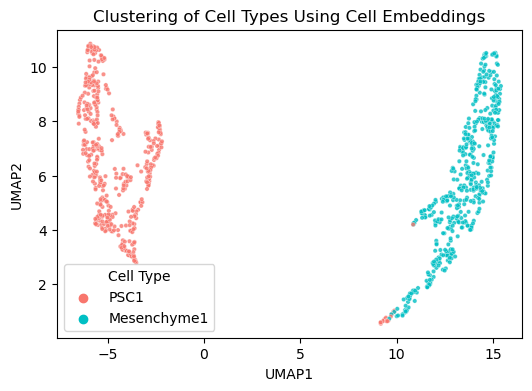

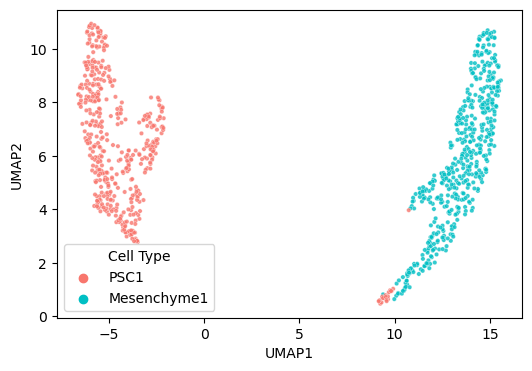

In [24]:
tr_file = '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/dev_model/in_silico_overexpress_cnot4_dict_1Kbatch_original.csv'
te_file = '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/dev_model/in_silico_overexpress_cnot4_dict_1Kbatch_perturb.csv'
experiment='oex'
title='Clustering of Cell Types Using Cell Embeddings'
legend_label='Cell Type'
X_tr, y_tr, X_te, y_te = getData(tr_file=tr_file, te_file=te_file, expt=experiment)
umap_model, df_umap_tr, df_umap_te, df_both = plotUmap(X_tr, y_tr, X_te, y_te,title,legend_label)

Delete

In [ ]:
tr_file = '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/dev_model/in_silico_delete_cnot1_dict_1Kbatch_original.csv'
te_file = '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/dev_model/in_silico_delete_cnot1_dict_1Kbatch_perturb.csv'
experiment = 'del'

X_tr, y_tr, X_te, y_te = getData(tr_file=tr_file, te_file=te_file, expt=experiment)

umap_model, df_umap_tr, df_umap_te, df_both = plotUmap(X_tr, y_tr, X_te, y_te)

KeyError: 'perturbation'

Overexpress

In [5]:
tr_file =  '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/original_emb/in_silico_overexpress__dict_1Kbatch_original.csv'
te_file = '/mnt/scratchc/ghlab/toby/in_silico_perturb_data/in_silico_pt_embs/original_emb/in_silico_overexpress__dict_1Kbatch_original.csv'
experiment = 'oex'

X_tr, y_tr, X_te, y_te = getData(tr_file=tr_file, te_file=te_file)

#umap_model, df_umap_tr, df_umap_te, df_both = plotUmap(X_tr, y_tr, X_te, y_te)

/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

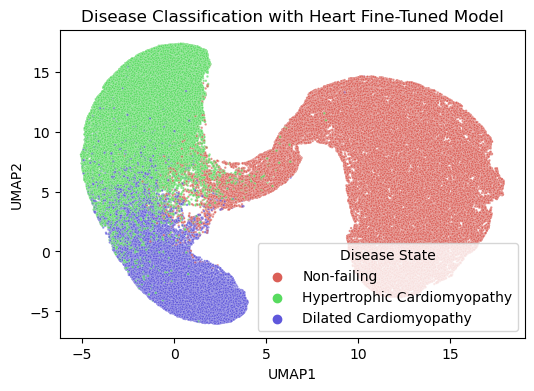

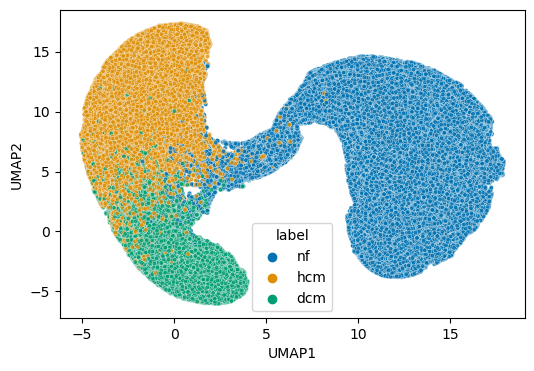

In [21]:
umap_model, df_umap_tr, df_umap_te, df_both = plotAlignedUmap(X_te, y_te, y_tr)

In [7]:
umap_model, df_umap_te = plotStateUmap(X_te, y_te, "/Users/clark04/toby/in_silico_perturb_data/extracted_emb_plots/hcm_oex_del_all.png")

NameError: name 'plotStateUmap' is not defined

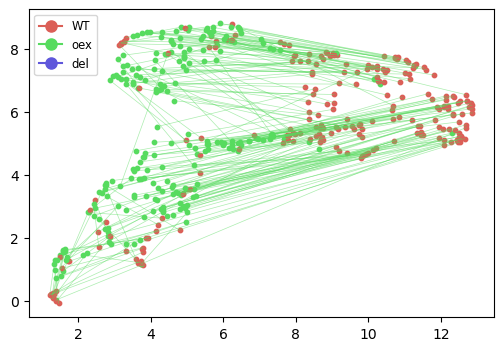

In [17]:
drawStateArrows(df_umap_te, df_umap_te['label'],"/Users/clark04/toby/in_silico_perturb_data/extracted_emb_plots/hcm_oex_arrows.png", 2)

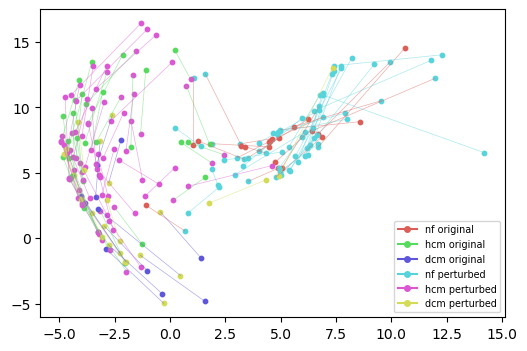

In [71]:
drawArrows(df_umap_te, df_umap_te['label'],"/Users/clark04/toby/in_silico_perturb_data/extracted_emb_plots/ccr4not_delete.png")

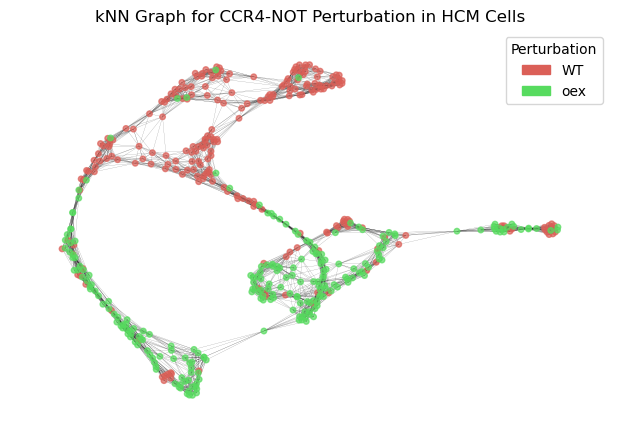

In [170]:
np.random.seed(0)
# Compute KNN graph
k = 15  # Number of neighbors
knn_graph = kneighbors_graph(df_umap_te[["var1","var2"]], k, mode='connectivity')

# Convert the kneighbors_graph to a NetworkX graph
knn_nx = nx.convert_matrix.from_scipy_sparse_array(knn_graph)

labels = df_umap_te['label'].tolist()  # Assuming 'Label' column contains labels
node_list = list(knn_nx.nodes())
label_mapping = dict(zip(node_list, labels))

# Add labels as node attributes to the NetworkX graph
nx.set_node_attributes(knn_nx, label_mapping, 'label')

labels = list(nx.get_node_attributes(knn_nx, 'label').values())

label_colours = sns.color_palette('hls',3)


# Create a dictionary to map labels to colors
label_color_mapping = {"WT":label_colours[0],"oex":label_colours[1], "del":label_colours[2]}

# Assign colors to nodes based on label information
node_colors = [label_color_mapping[labels[node]] for node in knn_nx.nodes()]

# Create legend handles for the unique labels and their assigned colors
legend_handles = [mpatches.Patch(color=label_color_mapping[label], label=str(label)) for label in set(labels)]
#legend_handles = [legend_handles[2], legend_handles[0], legend_handles[1]]
legend_handles = [legend_handles[1], legend_handles[0]]
# Draw the graph using matplotlib with colored nodes
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(knn_nx)  # Define the layout (spring layout for example)
nx.draw(knn_nx, pos=pos, node_color=node_colors, node_size=16, alpha=0.7, width=0.1)

# Display the custom legend representing the colors and labels
plt.legend(handles=legend_handles, title='Perturbation', loc='best')
plt.title('kNN Graph for CCR4-NOT Perturbation in HCM Cells')
plt.savefig("/mnt/scratchc/ghlab/toby/in_silico_perturb_data/extracted_emb_plots/hcm_oex_knn_7.png")
plt.show()


In [171]:
def getMatchingNeighbourFracState(graph, labels):
    prop_wt_neighbours_list = []
    prop_oex_neighbours_list = []
    prop_del_neighbours_list = []
    for i in range(len(graph)):
        if labels[i] == "WT":
            matching_neighbours = [1 if labels[i] == labels[node] else 0 for node in graph.neighbors(i)]
            prop_neighbours=sum(matching_neighbours)/len(matching_neighbours)
            prop_wt_neighbours_list.append(prop_neighbours)
        elif labels[i] == "oex":
            matching_neighbours = [1 if labels[i] == labels[node] else 0 for node in graph.neighbors(i)]
            prop_neighbours=sum(matching_neighbours)/len(matching_neighbours)
            prop_oex_neighbours_list.append(prop_neighbours)
        else:
            matching_neighbours = [1 if labels[i] == labels[node] else 0 for node in graph.neighbors(i)]
            prop_neighbours=sum(matching_neighbours)/len(matching_neighbours)
            prop_del_neighbours_list.append(prop_neighbours)
    mean_prop_wt_neighbours = np.mean(prop_wt_neighbours_list)
    mean_prop_oex_neighbours = np.mean(prop_oex_neighbours_list)
    mean_prop_del_neighbours = np.mean(prop_del_neighbours_list)
    print(f'Percentage of WT cell neighbours that are WT: {mean_prop_wt_neighbours * 100:.2f}%')
    print(f'Percentage of oex cell neighbours that are oex: {mean_prop_oex_neighbours * 100:.2f}%')
    print(f'Percentage of del cell neighbours that are del: {mean_prop_del_neighbours * 100:.2f}%')

    

In [93]:
def getMatchingNeighbourFrac(graph, labels):
    prop_neighbours_list = []
    for i in range(len(graph)):
            matching_neighbours = [1 if labels[i] == labels[node] else 0 for node in graph.neighbors(i)]
            prop_neighbours=sum(matching_neighbours)/len(matching_neighbours)
            prop_neighbours_list.append(prop_neighbours)  
    mean_prop_neighbours = np.mean(prop_neighbours_list)
    print(f'Percentage of neighbours in the same state: {mean_prop_neighbours * 100:.2f}%')

    

In [161]:
getMatchingNeighbourFrac(knn_nx, labels)

Percentage of neighbours in the same state: 83.29%


In [172]:
getMatchingNeighbourFracState(knn_nx, labels)

Percentage of WT cell neighbours that are WT: 78.06%
Percentage of oex cell neighbours that are oex: 78.67%
Percentage of del cell neighbours that are del: nan%


/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/clark04/anaconda3/envs/pkgtorch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
